## 0.提要

1.读取数据并进行转换

2.设置TensorBoard

3.写入TensorBoard

4.使用TensorBoard检查模型结构

5.使用TensorBoard创建交互式可视化

（包括两种检查训练数据的方法、跟踪训练表现、评估模型效果）

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
# 组合设置transform，转成tensor并进行Normalize
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('E:/dl_data/CV',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('E:/dl_data/CV',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# FashionMNIST数据集的类别
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
# 用于图片展示的函数
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [2]:
# 定义一个模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [3]:
# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 1.设置TensorBoard

In [4]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
# 定义一个SummaryWriter，这会在当前目录创建这个路径文件夹
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

## 2.写入TensorBoard

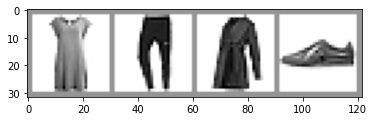

In [5]:
# 迭代取出一批数据
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 为这批图片创建grid
img_grid = torchvision.utils.make_grid(images)

# 调用前面的函数现实图片
matplotlib_imshow(img_grid, one_channel=True)

# 写入tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

In [13]:
# 在命令行中运行下面被注释的这个
# 1.写runs的完整路径
# 2.或者在这个文件目录路径中打开命令行
# 3.！+命令 就是在jupyter中运行命令行的方法（不建议在jupyter中使用，会堵塞下面的cell）
# http://localhost:6006/ 访问这个连接即可进入tensorboard
!tensorboard --logdir=runs

^C


## 3.使用TensorBoard检查模型

In [7]:
# 在运行这段之前，如果是使用了上面在jupyter中打开tensorboard的方式
# 应该先中断该行（前面那行带感叹号的），然后运行此行，再运行上面那行，刷新一下http://localhost:6006/的网页
# 上方多了一个graph
# 双击Net，就可以查看模型的结构了
writer.add_graph(net, images)
writer.close() # 执行close立即刷新，否则将每120秒自动刷新

## 4.给TensorBoard添加一个投影仪 “Projector”

高维数据的低维可视化

In [14]:
# 我们可以通过add_embedding方法可视化高维数据的低维表示

# 编写一个随机选出图片的函数
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    # 在传入的数据和标签中随机选出n组对应的数据
    
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# 随机选取训练集中的100组图片和对应的标签
images, labels = select_n_random(trainset.data, trainset.targets)

# 根据标签获取真正的类别名称
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

# projector这里我没有成功

## 5.使用TensorBoard跟踪模型训练

训练完后，tensorboard中出现scalars，可以查看训练集的损失曲线

images中出现了最后那个1000批的分类图片（应该是最后的1000批）

In [19]:
# 传入要预测的一批图片，返回其预测类别索引和概率
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    # 最大值及其索引,索引相当于类别
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    # 类别，对应的概率
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        # 前面的图片展示函数
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]], # 预测标签
            probs[idx] * 100.0, # 预测概率（置信度）
            classes[labels[idx]]), # 真实的标签
                     # 正确是绿色的，错误是红色的
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [20]:
running_loss = 0.0
for epoch in range(1):  # 遍历训练集的次数

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients 梯度清零在更新之后（这样也可以，还是更新之后）
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # 每1000个批次执行
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            # 通过.add_scalar向tensorboard添加损失记录（以前我们是直接print出来的）
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            # 通过.add_figure向tensorboard添加图片，这里绘制的是当前这个批次的图片
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


## 6.使用tensorboard评估训练模型

In [22]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run

# 存储批次的预测的概率和类别
class_probs = []
class_preds = []

# 推理、测试
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        # 一批预测的概率，所有类别的概率
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        # 一批预测类别
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function 
# 绘制pr曲线的函数
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
# 不同类别的pr曲线
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)